In [0]:
!wget https://raw.githubusercontent.com/tasdikrahman/datasets/master/email/csv/spam-apache.csv

--2019-10-13 19:33:35--  https://raw.githubusercontent.com/tasdikrahman/datasets/master/email/csv/spam-apache.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 366506 (358K) [text/plain]
Saving to: ‘spam-apache.csv’

spam-apache.csv     100%[===================>] 357.92K  --.-KB/s    in 0.02s   

2019-10-13 19:33:35 (20.4 MB/s) - ‘spam-apache.csv’ saved [366506/366506]



In [0]:
#80% of emails are for training 20% for testing good trainign set is balanced
#equal number of spam and not spam

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
data_spam = pd.read_csv('spam-apache.csv', header=0)
rows = data_spam.iloc[:, 0:2]
shuffle = np.random.permutation(np.shape(rows)[0])

rows = rows.iloc[shuffle]
training_size = int(len(rows) * .8)
training_set = rows[:training_size]
test_set = rows[training_size:]

In [0]:

# nr_train = 100
# tr = [data_spam.iloc[:nr_train, 0], data_spam.iloc[:nr_train, 1]]
# t = [data_spam.iloc[nr_train:, 0], data_spam.iloc[nr_train:, 1]]

# emails = [(re.sub(" +", " ", re.sub("[^a-zA-Z]", " ", email)) for email in tr[1])]
# labels = [int(n) for n in (tr[0] + 1) /2]
# constant = np.log( np.sum(np.where(np.array(labels)==0)) / np.sum(np.where(np.array(labels)==1)))
# pofx = {}
# for (ix, email) in enumerate(emails):
#   words = email.split(' ')
#   for word in words:
#     if word not in pofx:
#       counts = [0, 0]
#       counts[labels[ix]] = 1
#       pofx[word] = counts
#     else:
#       pofx[word][labels[ix]] += 1
# pofx1 = {i: [pofx[i][0]/np.sum(pofx[i])+ 0.000001, pofx[i][1]/np.sum(pofx[i])+ 0.000001]  for i in pofx}

# tables = [[i, np.log(  pofx[i][0]  /  pofx[i][1]  )] for i in pofx]
# tabs = {i[0]:i[1] for i in tables}

# #evaluation

# test_emails = [(re.sub(" +", " ", re.sub("[^a-zA-Z]", " ", email))) for email in t[1]]
# test_labels = [int(n) for n in (t[0] + 1)/2]

# correct = 0
# t1 = 0
# t2 = 0
# for (ix, email) in enumerate(test_emails):
#   words = email.split(" ")
#   ratio = 0
#   for word in words:
#     if word in tabs:
#       ratio += tabs[word]
#   if(ratio < 0):
#     guess = 1
#   else:
#     guess = 0
#   if(guess == test_labels[ix]):
#     correct += 1
#   else:
#     if(guess == 1 and test_labels[ix] == 0):
#       t1 += 1
#     else:
#       t2 += 1

      
# print("Correct classifications (percentage): ", correct/np.size(test_labels))
# print("T1 (percentage): ", t1/np.size(test_labels))
# print("T2 (percentage): ", t2/np.size(test_labels))

AttributeError: ignored

In [0]:
def cleanup(email):
  ignore = ['i','me','my','myself','we','our','ours','ourselves','you',"you're",
   "you've","you'll",'your','he','him','his','himself','she','her',
   'hers','herself','it',"it's",'its','itself','they','them','their','theirs',
   'what','which','who','this','that',"that'll",'these','those','am',
   'is','are','was','were','be','been','being','have','has','had','having',
   'do','does','did','doing','a','an','the','and','but','if','or','because',
   'as','until','while','of','at','by','for','with','about','against',
   'during','before','after','to','from','again','here','there', 'on',
   'when','where','why','how','all','any','no','only','own','same','too',
   'very','can','will','just','now',"didn't","haven't","isn't","wasn't",'·','', '>']
  
  words = re.sub("[^\w]", " ",  email).split()
  cleaned = []
  for word in words:
    if word.lower() not in ignore:
      cleaned.append(word.lower())
      
  #cleaned = [w.lower() for w in words if w.lower() not in ignore]
  return cleaned


In [0]:
allWords ={}
# splits dataset the first 80% into training and the rest into test

e = [training_set.iloc[:, 0], training_set.iloc[:, 1]]

# cleans up the training set and 
# adds words and occurences to ham/spam dictionaries

#gets a list of all words
for i in range(len(training_set)):
  email = e[1].iloc[i]
  words = cleanup(email)
  for word in words:
    if(word not in allWords):
      allWords[word] = 1
    else:
      allWords[word] += 1

#puts all words with occurences over 10 in vocab
vocab = {}
word_occurences = 0
for word in allWords:
  if (allWords[word] >= word_occurences):
    vocab[word] = 0



In [0]:
#counts the words for ham and spam
ham = vocab.copy()
spam = vocab.copy()
count_spam = 0
for i in range(len(training_set)):
  email = e[1].iloc[i]
  words = cleanup(email)
  if(e[0].iloc[i] == -1):#spam
    count_spam += 1
    for word in words:
      if(word in vocab):
        if(word in spam):
          spam[word] += 1
        else:
          spam[word] = 1
  else: #ham
    for word in words:
      if(word in vocab):
        if(word in ham):
          ham[word] += 1
        else:
          ham[word] = 1

count_ham = training_size - count_spam
# count_ham = sum(ham.values())
# count_spam = sum(spam.values())


count_all = count_ham + count_spam
print(len(ham))
print(count_ham, count_spam, count_all)

5864
103 96 199


In [0]:
# initializes a class dictionary and holds two seperate dictionaries of 
# probabilities of ham or spam for each word which are the features
features = {}
features['ham'] = {}
features['spam'] ={}

#populates the dictionaries
for word, count in ham.items():
  features['ham'][word] = np.log((int(count) + 1) / (count_ham + count_all))
for word, count in spam.items():
  features['spam'][word] = np.log((int(count) + 1) / (count_spam + count_all))

val_spam_pre = np.log(count_spam / count_all)
val_ham_pre  = np.log(count_ham / count_all)
smooth_ham  = np.log(1/count_ham + count_all)
smooth_spam = np.log(1/count_spam + count_all)



In [0]:
# Testing
e_test = [test_set.iloc[:, 0], test_set.iloc[:, 1]]
result = np.array([])
gt = np.array(e_test[0])
def test(words):
  val_spam = val_spam_pre
  val_ham  = val_ham_pre
  for feature in features:
    if feature == 'ham':
      for word in words:
        if word in features[feature]:
          val_ham += features[feature][word]
        else:
          val_ham += smooth_ham
    else:
      for word in words:
        if word in features[feature]:
          val_spam += features[feature][word]
        else:
          val_spam += smooth_spam
  if( val_ham >= val_spam ):
    result = 1
  else:
    result = -1
  return result

for i in range(len(test_set)):
  email = e_test[1].iloc[i]
  words = cleanup(email)
  # print('Ground Truth: ', e_test[0].iloc[i])
  result = np.append(result, test(words))
print(len(gt))
print(len(result))



50
50


Confusion Matrix:
[[0.42 0.02]
 [0.02 0.54]]
Accuracy:  96.0 %


<Figure size 720x720 with 0 Axes>

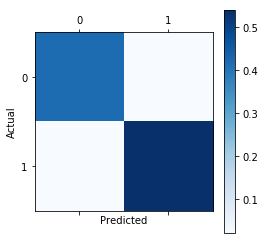

In [0]:
# Confusion Matrix


cm = np.zeros((2, 2))
for i, x in zip(gt, result):
  if (i == 1 and x == 1):
    cm[0][0] += 1
  elif(i == -1 and x == -1):
    cm[1][1] += 1
  elif(i == -1 and x == 1):
    cm[1][0] += 1
  elif(i == 1 and x == -1):
    cm[0][1] += 1
cm[0][0] = cm[0][0]/len(result)
cm[0][1] = cm[0][1]/len(result)
cm[1][0] = cm[1][0]/len(result)
cm[1][1] = cm[1][1]/len(result)

accuracy = float(cm[0][0] + cm[1][1]) * 100
print('Confusion Matrix:')
print(cm)
print('Accuracy: ',accuracy, '%')

plt.figure(figsize=(10,10))
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Confusion_matrix.jpg')

